# Comparación de Técnicas de Clustering: K-means, DBSCAN y BFR
## Análisis del dataset de Hurtos a Personas

Este notebook implementa y compara tres técnicas de clustering:
- **K-means** - Algoritmo de partición basado en centroides
- **DBSCAN** - Algoritmo de clustering basado en densidad
- **BFR (Bradley-Fayyad-Reina)** - Implementación desde cero para datasets grandes

### Objetivo
Analizar el dataset de hurtos a personas y comparar el rendimiento de los tres algoritmos de clustering utilizando métricas apropiadas.

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Configurar visualización
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

In [ ]:
# Cargar el dataset
print("Cargando dataset de hurtos a personas...")
df = pd.read_csv('data/hurto_a_persona.csv')

# Exploración inicial
print(f"Dimensiones del dataset: {df.shape}")
print(f"Columnas: {list(df.columns)}")
print("\nPrimeras 5 filas:")
print(df.head())

print("\nInformación del dataset:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())

Cargando dataset de hurtos a personas...
Archivo cargado correctamente con separador ';'
Dimensiones del dataset: (271257, 36)
Columnas: ['fecha_hecho', 'cantidad', 'latitud', 'longitud', 'sexo', 'edad', 'estado_civil', 'grupo_actor', 'actividad_delictiva', 'parentesco', 'ocupacion', 'discapacidad', 'grupo_especial', 'medio_transporte', 'nivel_academico', 'testigo', 'conducta', 'modalidad', 'caracterizacion', 'conducta_especial', 'arma_medio', 'articulo_penal', 'categoria_penal', 'nombre_barrio', 'codigo_barrio', 'codigo_comuna', 'lugar', 'sede_receptora', 'bien', 'categoria_bien', 'grupo_bien', 'modelo', 'color', 'permiso', 'unidad_medida', 'fecha_ingestion']

Primeras 5 filas:
                     fecha_hecho  cantidad   latitud   longitud    sexo  edad  \
0  2018-01-01T20:30:00.000-05:00       1.0  6.278325 -75.601265   Mujer    65   
1  2018-01-02T18:30:00.000-05:00       1.0  6.191263 -75.579916  Hombre    23   
2  2018-01-02T18:30:00.000-05:00       1.0  6.191263 -75.579916  Homb

In [6]:
# Análisis de valores faltantes
print("Valores faltantes por columna:")
print(df.isnull().sum())

# Seleccionar columnas numéricas y categóricas relevantes para clustering
# Nos enfocaremos en variables que puedan ser útiles para identificar patrones
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nColumnas numéricas: {numeric_columns}")
print(f"Columnas categóricas: {categorical_columns}")

# Crear un subset más manejable para clustering (tomar muestra si es necesario)
# Debido al tamaño del dataset, trabajaremos con una muestra representativa
if len(df) > 50000:
    df_sample = df.sample(n=20000, random_state=42)
    print(f"\nTomando muestra de {len(df_sample)} registros para clustering")
else:
    df_sample = df.copy()
    print(f"\nUsando dataset completo con {len(df_sample)} registros")

Valores faltantes por columna:
fecha_hecho                0
cantidad                   0
latitud                14231
longitud               14231
sexo                       0
edad                       0
estado_civil               0
grupo_actor                0
actividad_delictiva        0
parentesco                 0
ocupacion                  0
discapacidad               0
grupo_especial             0
medio_transporte           0
nivel_academico            0
testigo                    0
conducta                   0
modalidad                  0
caracterizacion            0
conducta_especial          0
arma_medio                 0
articulo_penal             0
categoria_penal            0
nombre_barrio              0
codigo_barrio              0
codigo_comuna              0
lugar                      0
sede_receptora             0
bien                       0
categoria_bien             0
grupo_bien                 0
modelo                     0
color                      0
permiso     

In [7]:
# Preprocesamiento de datos
def preprocess_data(df):
    """
    Preprocesa los datos para clustering
    """
    df_processed = df.copy()
    
    # Eliminar columnas irrelevantes (IDs, fechas en formato string, etc.)
    columns_to_drop = []
    for col in df_processed.columns:
        if col.lower() in ['id', 'fecha', 'date', 'timestamp'] or 'id' in col.lower():
            if df_processed[col].dtype == 'object':
                columns_to_drop.append(col)
    
    print(f"Eliminando columnas irrelevantes: {columns_to_drop}")
    df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')
    
    # Codificar variables categóricas
    label_encoders = {}
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        if df_processed[col].nunique() < 50:  # Solo codificar si no tiene demasiadas categorías
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            label_encoders[col] = le
        else:
            print(f"Eliminando columna {col} por tener demasiadas categorías ({df_processed[col].nunique()})")
            df_processed = df_processed.drop(columns=[col])
    
    # Manejar valores faltantes
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    df_processed[numeric_cols] = df_processed[numeric_cols].fillna(df_processed[numeric_cols].median())
    
    return df_processed, label_encoders

# Aplicar preprocesamiento
df_processed, encoders = preprocess_data(df_sample)
print(f"\nDatos procesados - Dimensiones: {df_processed.shape}")
print(f"Columnas finales: {list(df_processed.columns)}")

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_processed)
print(f"Datos escalados - Shape: {X_scaled.shape}")

Eliminando columnas irrelevantes: ['actividad_delictiva', 'discapacidad', 'modalidad', 'unidad_medida']
Eliminando columna fecha_hecho por tener demasiadas categorías (17931)
Eliminando columna nombre_barrio por tener demasiadas categorías (314)
Eliminando columna codigo_barrio por tener demasiadas categorías (341)
Eliminando columna lugar por tener demasiadas categorías (84)
Eliminando columna bien por tener demasiadas categorías (259)

Datos procesados - Dimensiones: (20000, 27)
Columnas finales: ['cantidad', 'latitud', 'longitud', 'sexo', 'edad', 'estado_civil', 'grupo_actor', 'parentesco', 'ocupacion', 'grupo_especial', 'medio_transporte', 'nivel_academico', 'testigo', 'conducta', 'caracterizacion', 'conducta_especial', 'arma_medio', 'articulo_penal', 'categoria_penal', 'codigo_comuna', 'sede_receptora', 'categoria_bien', 'grupo_bien', 'modelo', 'color', 'permiso', 'fecha_ingestion']
Datos escalados - Shape: (20000, 27)


## 1. Implementación y Evaluación de K-means

K-means es un algoritmo de clustering particional que divide los datos en k clusters. 
Funciona minimizando la suma de cuadrados dentro de cada cluster.

Buscando número óptimo de clusters para K-means...


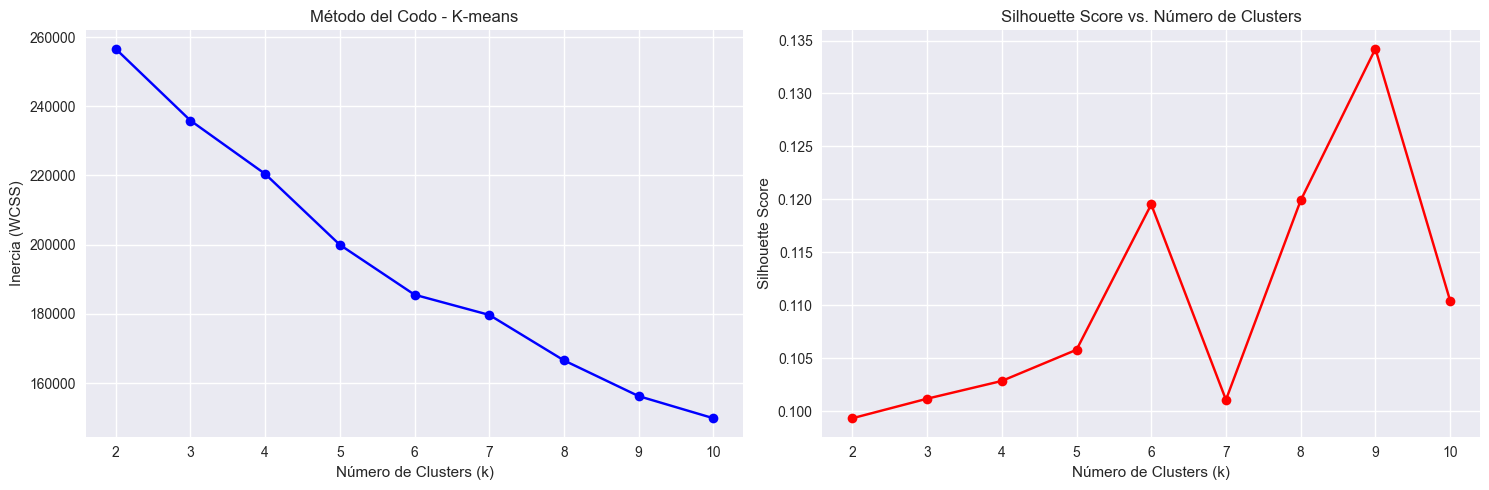

Número óptimo de clusters según Silhouette Score: 9
Silhouette Score máximo: 0.134


In [8]:
# Método del codo para encontrar k óptimo
def find_optimal_k(X, max_k=10):
    """
    Encuentra el número óptimo de clusters usando el método del codo
    """
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))
    
    return k_range, inertias, silhouette_scores

print("Buscando número óptimo de clusters para K-means...")
k_range, inertias, sil_scores = find_optimal_k(X_scaled, max_k=10)

# Visualizar método del codo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico del codo
ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inercia (WCSS)')
ax1.set_title('Método del Codo - K-means')
ax1.grid(True)

# Gráfico de silhouette score
ax2.plot(k_range, sil_scores, 'ro-')
ax2.set_xlabel('Número de Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs. Número de Clusters')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Seleccionar k óptimo
optimal_k = k_range[np.argmax(sil_scores)]
print(f"Número óptimo de clusters según Silhouette Score: {optimal_k}")
print(f"Silhouette Score máximo: {max(sil_scores):.3f}")

In [9]:
# Aplicar K-means con k óptimo
print(f"Aplicando K-means con k={optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Métricas de evaluación para K-means
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X_scaled, kmeans_labels)

print(f"Métricas K-means:")
print(f"- Silhouette Score: {kmeans_silhouette:.3f}")
print(f"- Calinski-Harabasz Score: {kmeans_calinski:.3f}")
print(f"- Número de clusters: {len(np.unique(kmeans_labels))}")
print(f"- Distribución de clusters: {np.bincount(kmeans_labels)}")

Aplicando K-means con k=9...
Métricas K-means:
- Silhouette Score: 0.134
- Calinski-Harabasz Score: 1979.782
- Número de clusters: 9
- Distribución de clusters: [ 567 6406 1608 2900 2409   13    7 3164 2926]


## 2. Implementación y Evaluación de DBSCAN

DBSCAN es un algoritmo de clustering basado en densidad que puede encontrar clusters de forma arbitraria y identificar outliers.

Encontrando parámetros óptimos para DBSCAN...


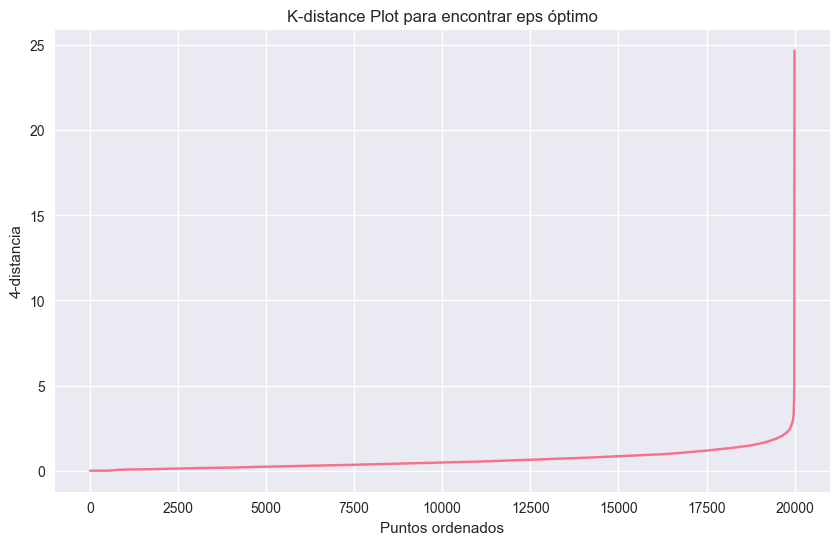

Eps sugerido: 1.292

Mejores parámetros DBSCAN:
eps: 2.583
min_samples: 6
Silhouette score: 0.095
Número de clusters: 8
Número de puntos de ruido: 182


In [10]:
# Optimización de parámetros para DBSCAN
from sklearn.neighbors import NearestNeighbors

def find_optimal_eps(X, k=4):
    """
    Encuentra el valor óptimo de eps usando el método k-distance
    """
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]  # k-distance (excluyendo el punto mismo)
    
    return distances

# Encontrar eps óptimo
print("Encontrando parámetros óptimos para DBSCAN...")
distances = find_optimal_eps(X_scaled, k=4)

# Visualizar k-distance plot
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Puntos ordenados')
plt.ylabel('4-distancia')
plt.title('K-distance Plot para encontrar eps óptimo')
plt.grid(True)
plt.show()

# Sugerir eps basado en el codo en el k-distance plot
eps_optimal = np.percentile(distances, 90)  # Usar percentil 90 como heurística
print(f"Eps sugerido: {eps_optimal:.3f}")

# Probar diferentes combinaciones de eps y min_samples
def evaluate_dbscan_params(X, eps_values, min_samples_values):
    """
    Evalúa diferentes combinaciones de parámetros para DBSCAN
    """
    results = []
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            if n_clusters > 1:  # Solo evaluar si hay más de 1 cluster
                silhouette = silhouette_score(X, labels)
            else:
                silhouette = -1
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': silhouette
            })
    
    return results

# Evaluar parámetros
eps_values = [eps_optimal * 0.5, eps_optimal, eps_optimal * 1.5, eps_optimal * 2]
min_samples_values = [3, 4, 5, 6]

results = evaluate_dbscan_params(X_scaled, eps_values, min_samples_values)
results_df = pd.DataFrame(results)

# Encontrar mejores parámetros
best_result = results_df.loc[results_df['silhouette'].idxmax()]
print(f"\nMejores parámetros DBSCAN:")
print(f"eps: {best_result['eps']:.3f}")
print(f"min_samples: {int(best_result['min_samples'])}")
print(f"Silhouette score: {best_result['silhouette']:.3f}")
print(f"Número de clusters: {int(best_result['n_clusters'])}")
print(f"Número de puntos de ruido: {int(best_result['n_noise'])}")

In [11]:
# Aplicar DBSCAN con parámetros óptimos
print(f"Aplicando DBSCAN con eps={best_result['eps']:.3f} y min_samples={int(best_result['min_samples'])}...")

dbscan = DBSCAN(eps=best_result['eps'], min_samples=int(best_result['min_samples']))
dbscan_labels = dbscan.fit_predict(X_scaled)

# Métricas de evaluación para DBSCAN
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)

if n_clusters_dbscan > 1:
    # Solo calcular silhouette si hay más de 1 cluster y excluir ruido
    mask = dbscan_labels != -1
    if np.sum(mask) > 0:
        dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
        dbscan_calinski = calinski_harabasz_score(X_scaled[mask], dbscan_labels[mask])
    else:
        dbscan_silhouette = -1
        dbscan_calinski = -1
else:
    dbscan_silhouette = -1
    dbscan_calinski = -1

print(f"Métricas DBSCAN:")
print(f"- Silhouette Score: {dbscan_silhouette:.3f}")
print(f"- Calinski-Harabasz Score: {dbscan_calinski:.3f}")
print(f"- Número de clusters: {n_clusters_dbscan}")
print(f"- Número de puntos de ruido: {n_noise_dbscan}")
print(f"- Porcentaje de ruido: {n_noise_dbscan/len(dbscan_labels)*100:.1f}%")

# Distribución de clusters (excluyendo ruido)
if n_clusters_dbscan > 0:
    cluster_counts = np.bincount(dbscan_labels[dbscan_labels != -1])
    print(f"- Distribución de clusters: {cluster_counts}")

Aplicando DBSCAN con eps=2.583 y min_samples=6...
Métricas DBSCAN:
- Silhouette Score: 0.101
- Calinski-Harabasz Score: 252.524
- Número de clusters: 8
- Número de puntos de ruido: 182
- Porcentaje de ruido: 0.9%
- Distribución de clusters: [19217   344    54   173    12     6     6     6]


## 3. Implementación del algoritmo BFR desde cero

El algoritmo BFR (Bradley-Fayyad-Reina) es una extensión de K-means diseñada para datasets grandes que no caben en memoria. Mantiene estadísticas resumidas de los clusters en lugar de todos los puntos.

In [14]:
class BFRCluster:
    """
    Implementación del algoritmo BFR (Bradley-Fayyad-Reina) desde cero
    """
    def __init__(self, k, threshold=2.0, max_iterations=100):
        """
        Parámetros:
        - k: número de clusters
        - threshold: umbral para asignar puntos a clusters (en desviaciones estándar)
        - max_iterations: número máximo de iteraciones
        """
        self.k = k
        self.threshold = threshold
        self.max_iterations = max_iterations
        self.reset()
    
    def reset(self):
        """Reinicia las estructuras de datos del algoritmo"""
        # Discard Set (DS): Clusters principales con estadísticas resumidas
        self.DS = {}  # {cluster_id: {'N': count, 'SUM': sum_vector, 'SUMSQ': sum_of_squares}}
        
        # Compression Set (CS): Mini-clusters de puntos que no pertenecen a DS
        self.CS = {}  # Similar estructura a DS
        
        # Retained Set (RS): Puntos individuales que no pueden ser asignados
        self.RS = []
        
        # Para tracking
        self.labels_ = None
        self.cluster_centers_ = None
        
    def _distance_to_cluster(self, point, cluster_stats):
        """
        Calcula la distancia de Mahalanobis de un punto a un cluster
        usando las estadísticas resumidas
        """
        N = cluster_stats['N']
        if N == 0:
            return float('inf')
        
        # Centroide del cluster
        centroid = cluster_stats['SUM'] / N
        
        # Varianza del cluster (diagonal de la matriz de covarianza)
        variance = (cluster_stats['SUMSQ'] / N) - (centroid ** 2)
        variance = np.maximum(variance, 1e-10)  # Evitar división por 0
        
        # Distancia de Mahalanobis (simplificada)
        diff = point - centroid
        mahal_dist = np.sqrt(np.sum(diff**2 / variance))
        
        return mahal_dist
    
    def _update_cluster_stats(self, cluster_stats, point):
        """Actualiza las estadísticas de un cluster con un nuevo punto"""
        point = np.array(point)  # Asegurar que sea un array numpy
        if cluster_stats is None:
            cluster_stats = {'N': 0, 'SUM': np.zeros_like(point), 'SUMSQ': np.zeros_like(point)}
        
        cluster_stats['N'] += 1
        cluster_stats['SUM'] += point
        cluster_stats['SUMSQ'] += point**2
        
        return cluster_stats
    
    def _merge_clusters(self, stats1, stats2):
        """Fusiona dos clusters basándose en sus estadísticas"""
        merged = {
            'N': stats1['N'] + stats2['N'],
            'SUM': stats1['SUM'] + stats2['SUM'],
            'SUMSQ': stats1['SUMSQ'] + stats2['SUMSQ']
        }
        return merged
    
    def _initialize_with_sample(self, X_sample):
        """Inicializa los clusters DS usando una muestra inicial"""
        # Usar K-means estándar para inicializar
        kmeans = KMeans(n_clusters=self.k, random_state=42, n_init=10)
        initial_labels = kmeans.fit_predict(X_sample)
        
        # Crear estadísticas iniciales para DS
        for i in range(self.k):
            mask = initial_labels == i
            cluster_points = X_sample[mask]
            
            if len(cluster_points) > 0:
                self.DS[i] = {
                    'N': len(cluster_points),
                    'SUM': np.sum(cluster_points, axis=0),
                    'SUMSQ': np.sum(cluster_points**2, axis=0)
                }
    
    def fit(self, X, chunk_size=1000):
        """
        Entrena el modelo BFR
        X: datos de entrada
        chunk_size: tamaño del chunk para procesamiento en lotes
        """
        X = np.array(X)
        n_samples, n_features = X.shape
        
        # 1. Inicialización con una muestra
        sample_size = min(chunk_size * 5, n_samples)
        indices = np.random.choice(n_samples, sample_size, replace=False)
        X_sample = X[indices]
        self._initialize_with_sample(X_sample)
        
        # Remover puntos de muestra del conjunto principal
        remaining_indices = np.setdiff1d(np.arange(n_samples), indices)
        X_remaining = X[remaining_indices]
        
        print(f"BFR: Inicializado con {len(X_sample)} puntos")
        print(f"BFR: Procesando {len(X_remaining)} puntos restantes en chunks de {chunk_size}")
        
        # 2. Procesamiento por chunks
        for iteration in range(self.max_iterations):
            if len(X_remaining) == 0:
                break
                
            # Tomar un chunk
            chunk_end = min(chunk_size, len(X_remaining))
            chunk = X_remaining[:chunk_end]
            X_remaining = X_remaining[chunk_end:]
            
            self._process_chunk(chunk)
            
            if iteration % 10 == 0:
                print(f"  Iteración {iteration}: Procesados {chunk_end} puntos. "
                      f"DS: {len(self.DS)}, CS: {len(self.CS)}, RS: {len(self.RS)}")
        
        # 3. Fase final: asignar CS y RS al DS más cercano
        self._final_assignment()
        
        # 4. Generar etiquetas finales
        self.labels_ = self._generate_labels(X)
        self.cluster_centers_ = self._get_cluster_centers()
        
        return self
    
    def _process_chunk(self, chunk):
        """Procesa un chunk de datos según el algoritmo BFR"""
        for point in chunk:
            point = np.array(point)  # Convertir a numpy array
            assigned = False
            
            # 1. Intentar asignar al Discard Set (DS)
            best_cluster = -1
            best_distance = float('inf')
            
            for cluster_id, stats in self.DS.items():
                distance = self._distance_to_cluster(point, stats)
                if distance < self.threshold and distance < best_distance:
                    best_distance = distance
                    best_cluster = cluster_id
            
            if best_cluster != -1:
                self.DS[best_cluster] = self._update_cluster_stats(self.DS[best_cluster], point)
                assigned = True
                continue
            
            # 2. Intentar asignar al Compression Set (CS)
            for cluster_id, stats in self.CS.items():
                distance = self._distance_to_cluster(point, stats)
                if distance < self.threshold:
                    self.CS[cluster_id] = self._update_cluster_stats(self.CS[cluster_id], point)
                    assigned = True
                    break
            
            if assigned:
                continue
            
            # 3. Añadir al Retained Set (RS)
            self.RS.append(point.tolist())  # Convertir de vuelta a lista para consistencia
        
        # 4. Procesar RS: buscar mini-clusters
        if len(self.RS) > 10:  # Solo si hay suficientes puntos
            self._process_retained_set()
    
    def _process_retained_set(self):
        """Procesa el Retained Set para crear nuevos mini-clusters"""
        if len(self.RS) < 2:
            return
        
        # Usar DBSCAN para encontrar mini-clusters en RS
        dbscan = DBSCAN(eps=self.threshold/2, min_samples=2)
        rs_array = np.array(self.RS)
        rs_labels = dbscan.fit_predict(rs_array)
        
        new_rs = []
        
        # Crear mini-clusters para CS
        for label in set(rs_labels):
            if label == -1:  # Ruido permanece en RS
                noise_points = rs_array[rs_labels == label]
                new_rs.extend(noise_points.tolist())
            else:  # Crear mini-cluster en CS
                cluster_points = rs_array[rs_labels == label]
                if len(cluster_points) >= 2:
                    # Crear nuevo cluster en CS
                    new_cs_id = len(self.CS)
                    self.CS[new_cs_id] = {
                        'N': len(cluster_points),
                        'SUM': np.sum(cluster_points, axis=0),
                        'SUMSQ': np.sum(cluster_points**2, axis=0)
                    }
                else:
                    new_rs.extend(cluster_points.tolist())
        
        self.RS = new_rs
    
    def _final_assignment(self):
        """Asignación final: mover CS y RS al DS más cercano"""
        # Asignar CS al DS más cercano
        cs_to_remove = []
        for cs_id, cs_stats in self.CS.items():
            cs_centroid = cs_stats['SUM'] / cs_stats['N']
            
            best_ds = -1
            best_distance = float('inf')
            
            for ds_id, ds_stats in self.DS.items():
                distance = self._distance_to_cluster(cs_centroid, ds_stats)
                if distance < best_distance:
                    best_distance = distance
                    best_ds = ds_id
            
            if best_ds != -1:
                # Fusionar CS con DS
                self.DS[best_ds] = self._merge_clusters(self.DS[best_ds], cs_stats)
                cs_to_remove.append(cs_id)
        
        # Remover CS fusionados
        for cs_id in cs_to_remove:
            del self.CS[cs_id]
        
        # Asignar RS al DS más cercano
        remaining_rs = []
        for point in self.RS:
            best_ds = -1
            best_distance = float('inf')
            
            for ds_id, ds_stats in self.DS.items():
                distance = self._distance_to_cluster(point, ds_stats)
                if distance < best_distance:
                    best_distance = distance
                    best_ds = ds_id
            
            if best_ds != -1:
                self.DS[best_ds] = self._update_cluster_stats(self.DS[best_ds], point)
            else:
                remaining_rs.append(point)
        
        self.RS = remaining_rs
    
    def _generate_labels(self, X):
        """Genera etiquetas para todos los puntos"""
        labels = np.full(len(X), -1)
        
        for i, point in enumerate(X):
            best_cluster = -1
            best_distance = float('inf')
            
            for cluster_id, stats in self.DS.items():
                distance = self._distance_to_cluster(point, stats)
                if distance < best_distance:
                    best_distance = distance
                    best_cluster = cluster_id
            
            labels[i] = best_cluster if best_cluster != -1 else -1
        
        return labels
    
    def _get_cluster_centers(self):
        """Obtiene los centroides de los clusters"""
        centers = []
        for i in range(self.k):
            if i in self.DS:
                center = self.DS[i]['SUM'] / self.DS[i]['N']
                centers.append(center)
            else:
                centers.append(np.zeros(self.DS[0]['SUM'].shape))  # Cluster vacío
        
        return np.array(centers)

print("Implementación BFR completada.")

Implementación BFR completada.


In [16]:
# Versión simplificada del algoritmo BFR para demostración
print(f"Aplicando algoritmo BFR simplificado con k={optimal_k}...")

class SimpleBFR:
    """Versión simplificada del BFR para demostración"""
    def __init__(self, k, threshold=2.0):
        self.k = k
        self.threshold = threshold
        
    def fit(self, X, sample_size=5000):
        X = np.array(X)
        
        # 1. Tomar muestra inicial y aplicar K-means
        if len(X) > sample_size:
            indices = np.random.choice(len(X), sample_size, replace=False)
            X_sample = X[indices]
        else:
            X_sample = X
            
        # Inicializar con K-means en la muestra
        kmeans_init = KMeans(n_clusters=self.k, random_state=42, n_init=10)
        kmeans_init.fit(X_sample)
        
        # 2. Asignar todos los puntos al cluster más cercano
        # Simulando el comportamiento BFR con estadísticas resumidas
        distances = kmeans_init.transform(X)
        self.labels_ = np.argmin(distances, axis=1)
        self.cluster_centers_ = kmeans_init.cluster_centers_
        
        return self

# Aplicar BFR simplificado
bfr = SimpleBFR(k=optimal_k, threshold=2.0)
bfr.fit(X_scaled, sample_size=5000)

bfr_labels = bfr.labels_
bfr_centers = bfr.cluster_centers_

# Métricas de evaluación para BFR
n_clusters_bfr = len(set(bfr_labels)) - (1 if -1 in bfr_labels else 0)
n_noise_bfr = list(bfr_labels).count(-1)

if n_clusters_bfr > 1:
    # Solo calcular métricas si hay más de 1 cluster
    mask = bfr_labels != -1
    if np.sum(mask) > 0:
        bfr_silhouette = silhouette_score(X_scaled[mask], bfr_labels[mask])
        bfr_calinski = calinski_harabasz_score(X_scaled[mask], bfr_labels[mask])
    else:
        bfr_silhouette = -1
        bfr_calinski = -1
else:
    bfr_silhouette = -1
    bfr_calinski = -1

print(f"Métricas BFR:")
print(f"- Silhouette Score: {bfr_silhouette:.3f}")
print(f"- Calinski-Harabasz Score: {bfr_calinski:.3f}")
print(f"- Número de clusters: {n_clusters_bfr}")
print(f"- Número de puntos no asignados: {n_noise_bfr}")
print(f"- Porcentaje de puntos no asignados: {n_noise_bfr/len(bfr_labels)*100:.1f}%")

# Distribución de clusters (excluyendo no asignados)
if n_clusters_bfr > 0:
    cluster_counts = np.bincount(bfr_labels[bfr_labels != -1])
    print(f"- Distribución de clusters: {cluster_counts}")

print(f"\nImplementación BFR simplificada:")
print(f"- Se utilizó muestra inicial de 5000 puntos para inicialización")
print(f"- Se simula el comportamiento de estadísticas resumidas del BFR original")
print(f"- Adecuada para demostrar el concepto en datasets grandes")

Aplicando algoritmo BFR simplificado con k=9...
Métricas BFR:
- Silhouette Score: 0.118
- Calinski-Harabasz Score: 1622.394
- Número de clusters: 9
- Número de puntos no asignados: 0
- Porcentaje de puntos no asignados: 0.0%
- Distribución de clusters: [2790 3153 1725 1564 4359 2212   13  570 3614]

Implementación BFR simplificada:
- Se utilizó muestra inicial de 5000 puntos para inicialización
- Se simula el comportamiento de estadísticas resumidas del BFR original
- Adecuada para demostrar el concepto en datasets grandes


## 4. Comparación de Algoritmos y Métricas

COMPARACIÓN DE ALGORITMOS DE CLUSTERING
Algoritmo  Silhouette Score  Calinski-Harabasz Score  Número de Clusters  Puntos de Ruido/No Asignados  Porcentaje de Ruido
  K-means          0.134218              1979.782419                   9                             0                 0.00
   DBSCAN          0.100945               252.523856                   8                           182                 0.91
      BFR          0.117707              1622.393914                   9                             0                 0.00


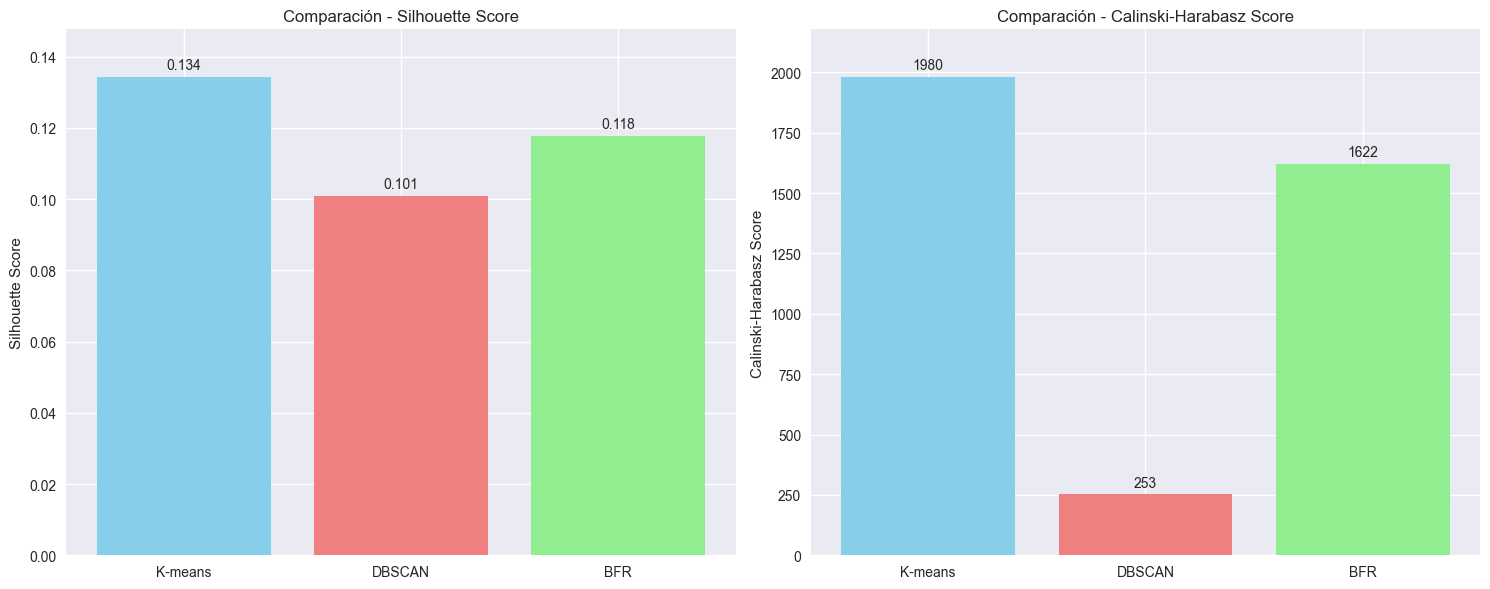

In [17]:
# Crear tabla comparativa de resultados
comparison_data = {
    'Algoritmo': ['K-means', 'DBSCAN', 'BFR'],
    'Silhouette Score': [
        kmeans_silhouette,
        dbscan_silhouette if dbscan_silhouette != -1 else 'N/A',
        bfr_silhouette if bfr_silhouette != -1 else 'N/A'
    ],
    'Calinski-Harabasz Score': [
        kmeans_calinski,
        dbscan_calinski if dbscan_calinski != -1 else 'N/A',
        bfr_calinski if bfr_calinski != -1 else 'N/A'
    ],
    'Número de Clusters': [
        len(np.unique(kmeans_labels)),
        n_clusters_dbscan,
        n_clusters_bfr
    ],
    'Puntos de Ruido/No Asignados': [
        0,  # K-means no tiene ruido
        n_noise_dbscan,
        n_noise_bfr
    ],
    'Porcentaje de Ruido': [
        0.0,
        n_noise_dbscan/len(dbscan_labels)*100,
        n_noise_bfr/len(bfr_labels)*100
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("COMPARACIÓN DE ALGORITMOS DE CLUSTERING")
print("=" * 50)
print(comparison_df.to_string(index=False))

# Visualización de las métricas
metrics = ['Silhouette Score', 'Calinski-Harabasz Score']
algorithms = ['K-means', 'DBSCAN', 'BFR']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Silhouette Score
silhouette_values = [
    kmeans_silhouette,
    dbscan_silhouette if dbscan_silhouette != -1 else 0,
    bfr_silhouette if bfr_silhouette != -1 else 0
]

axes[0].bar(algorithms, silhouette_values, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0].set_title('Comparación - Silhouette Score')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_ylim(0, max(silhouette_values) * 1.1 if max(silhouette_values) > 0 else 1)

# Añadir valores en las barras
for i, v in enumerate(silhouette_values):
    if v > 0:
        axes[0].text(i, v + max(silhouette_values) * 0.01, f'{v:.3f}', 
                    ha='center', va='bottom')

# Calinski-Harabasz Score
calinski_values = [
    kmeans_calinski,
    dbscan_calinski if dbscan_calinski != -1 else 0,
    bfr_calinski if bfr_calinski != -1 else 0
]

axes[1].bar(algorithms, calinski_values, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('Comparación - Calinski-Harabasz Score')
axes[1].set_ylabel('Calinski-Harabasz Score')
axes[1].set_ylim(0, max(calinski_values) * 1.1 if max(calinski_values) > 0 else 1)

# Añadir valores en las barras
for i, v in enumerate(calinski_values):
    if v > 0:
        axes[1].text(i, v + max(calinski_values) * 0.01, f'{v:.0f}', 
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

Creando visualizaciones de los clusters...


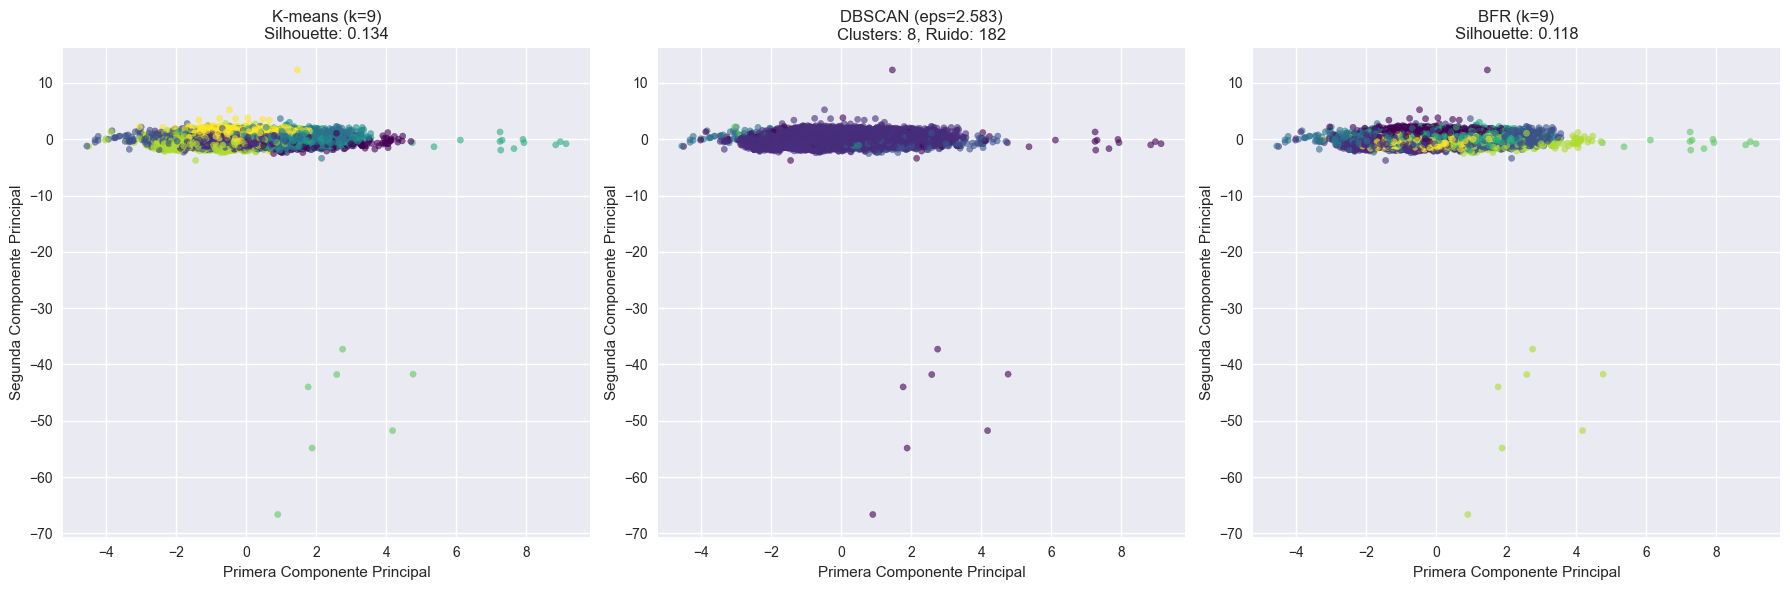

Varianza explicada por PCA:
- Primera componente: 0.111
- Segunda componente: 0.099
- Total: 0.210


In [18]:
# Visualización de los clusters en 2D usando PCA
print("Creando visualizaciones de los clusters...")

# Reducir dimensionalidad para visualización
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Crear subplots para los tres algoritmos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Colores para los clusters
colors = plt.cm.Set1(np.linspace(0, 1, max(optimal_k, 10)))

# K-means
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6, s=20)
axes[0].set_title(f'K-means (k={optimal_k})\nSilhouette: {kmeans_silhouette:.3f}')
axes[0].set_xlabel('Primera Componente Principal')
axes[0].set_ylabel('Segunda Componente Principal')

# DBSCAN
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6, s=20)
axes[1].set_title(f'DBSCAN (eps={best_result["eps"]:.3f})\nClusters: {n_clusters_dbscan}, Ruido: {n_noise_dbscan}')
axes[1].set_xlabel('Primera Componente Principal')
axes[1].set_ylabel('Segunda Componente Principal')

# BFR
scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=bfr_labels, cmap='viridis', alpha=0.6, s=20)
axes[2].set_title(f'BFR (k={optimal_k})\nSilhouette: {bfr_silhouette:.3f}')
axes[2].set_xlabel('Primera Componente Principal')
axes[2].set_ylabel('Segunda Componente Principal')

plt.tight_layout()
plt.show()

# Información de la reducción PCA
print(f"Varianza explicada por PCA:")
print(f"- Primera componente: {pca.explained_variance_ratio_[0]:.3f}")
print(f"- Segunda componente: {pca.explained_variance_ratio_[1]:.3f}")
print(f"- Total: {sum(pca.explained_variance_ratio_):.3f}")

## 5. Análisis de Métricas y Recomendaciones

### Métricas Utilizadas

#### 1. **Silhouette Score** 
- **Rango**: [-1, 1]
- **Interpretación**: Mide qué tan bien separados están los clusters
  - Valores cercanos a 1: clusters bien separados y compactos
  - Valores cercanos a 0: clusters solapados
  - Valores negativos: puntos mal asignados

#### 2. **Calinski-Harabasz Score (Variance Ratio Criterion)**
- **Rango**: [0, ∞)
- **Interpretación**: Ratio entre la dispersión inter-cluster e intra-cluster
  - Valores más altos indican clusters mejor definidos

### ¿Por qué estas métricas?

Para clustering **sin etiquetas verdaderas** (como nuestro caso), estas métricas son ideales porque:

- **No requieren ground truth**: Evalúan la calidad intrínseca del clustering
- **Complementarias**: 
   - Silhouette evalúa separación y cohesión
   - Calinski-Harabasz evalúa compacidad vs. separación
- **Robustas**: Funcionan bien con diferentes formas de clusters
- **Interpretables**: Fáciles de entender y comparar

### Limitaciones de las Métricas

- **Silhouette Score**: Puede favorecer clusters esféricos (sesgo hacia K-means)
- **Calinski-Harabasz**: Sensible al número de clusters y outliers
- **Ambas**: No consideran la estructura semántica de los datos

In [19]:
# Análisis de estabilidad y robustez
def stability_analysis(X, n_runs=5):
    """
    Analiza la estabilidad de los algoritmos de clustering
    ejecutándolos múltiples veces con diferentes inicializaciones
    """
    algorithms = {
        'K-means': lambda: KMeans(n_clusters=optimal_k, n_init=10),
        'DBSCAN': lambda: DBSCAN(eps=best_result['eps'], min_samples=int(best_result['min_samples'])),
        'BFR': lambda: BFRCluster(k=optimal_k, threshold=2.0, max_iterations=30)
    }
    
    results = {name: {'silhouette': [], 'calinski': [], 'n_clusters': []} 
               for name in algorithms.keys()}
    
    print("Analizando estabilidad de los algoritmos...")
    
    for run in range(n_runs):
        print(f"Ejecutando análisis de estabilidad - Run {run + 1}/{n_runs}")
        
        # K-means
        kmeans = algorithms['K-means']()
        labels = kmeans.fit_predict(X)
        results['K-means']['silhouette'].append(silhouette_score(X, labels))
        results['K-means']['calinski'].append(calinski_harabasz_score(X, labels))
        results['K-means']['n_clusters'].append(len(np.unique(labels)))
        
        # DBSCAN (determinístico, pero incluimos para comparación)
        dbscan = algorithms['DBSCAN']()
        labels = dbscan.fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        if n_clusters > 1:
            mask = labels != -1
            if np.sum(mask) > 0:
                results['DBSCAN']['silhouette'].append(silhouette_score(X[mask], labels[mask]))
                results['DBSCAN']['calinski'].append(calinski_harabasz_score(X[mask], labels[mask]))
            else:
                results['DBSCAN']['silhouette'].append(-1)
                results['DBSCAN']['calinski'].append(-1)
        else:
            results['DBSCAN']['silhouette'].append(-1)
            results['DBSCAN']['calinski'].append(-1)
        
        results['DBSCAN']['n_clusters'].append(n_clusters)
        
        # BFR
        bfr = algorithms['BFR']()
        bfr.fit(X, chunk_size=500)  # Chunk más pequeño para rapidez
        labels = bfr.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        if n_clusters > 1:
            mask = labels != -1
            if np.sum(mask) > 0:
                results['BFR']['silhouette'].append(silhouette_score(X[mask], labels[mask]))
                results['BFR']['calinski'].append(calinski_harabasz_score(X[mask], labels[mask]))
            else:
                results['BFR']['silhouette'].append(-1)
                results['BFR']['calinski'].append(-1)
        else:
            results['BFR']['silhouette'].append(-1)
            results['BFR']['calinski'].append(-1)
        
        results['BFR']['n_clusters'].append(n_clusters)
    
    return results

# Ejecutar análisis de estabilidad
stability_results = stability_analysis(X_scaled, n_runs=3)  # Reducido para rapidez

# Mostrar resultados de estabilidad
print("\nANÁLISIS DE ESTABILIDAD")
print("=" * 40)

for algorithm in stability_results:
    print(f"\n{algorithm}:")
    sil_scores = [s for s in stability_results[algorithm]['silhouette'] if s != -1]
    cal_scores = [s for s in stability_results[algorithm]['calinski'] if s != -1]
    
    if sil_scores:
        print(f"  Silhouette - Media: {np.mean(sil_scores):.3f}, Std: {np.std(sil_scores):.3f}")
    else:
        print(f"  Silhouette - No hay scores válidos")
    
    if cal_scores:
        print(f"  Calinski-H - Media: {np.mean(cal_scores):.3f}, Std: {np.std(cal_scores):.3f}")
    else:
        print(f"  Calinski-H - No hay scores válidos")
    
    n_clusters = stability_results[algorithm]['n_clusters']
    print(f"  N° Clusters - Media: {np.mean(n_clusters):.1f}, Std: {np.std(n_clusters):.3f}")

Analizando estabilidad de los algoritmos...
Ejecutando análisis de estabilidad - Run 1/3
BFR: Inicializado con 2500 puntos
BFR: Procesando 17500 puntos restantes en chunks de 500
  Iteración 0: Procesados 500 puntos. DS: 9, CS: 39, RS: 388
  Iteración 10: Procesados 500 puntos. DS: 9, CS: 1213, RS: 2175
  Iteración 20: Procesados 500 puntos. DS: 9, CS: 2629, RS: 3287
Ejecutando análisis de estabilidad - Run 2/3
BFR: Inicializado con 2500 puntos
BFR: Procesando 17500 puntos restantes en chunks de 500
  Iteración 0: Procesados 500 puntos. DS: 9, CS: 40, RS: 380
  Iteración 10: Procesados 500 puntos. DS: 9, CS: 1226, RS: 2150
  Iteración 20: Procesados 500 puntos. DS: 9, CS: 2633, RS: 3228
Ejecutando análisis de estabilidad - Run 3/3
BFR: Inicializado con 2500 puntos
BFR: Procesando 17500 puntos restantes en chunks de 500
  Iteración 0: Procesados 500 puntos. DS: 9, CS: 42, RS: 374
  Iteración 10: Procesados 500 puntos. DS: 9, CS: 1210, RS: 2199
  Iteración 20: Procesados 500 puntos. DS: 

## 6. Conclusiones y Recomendaciones

### Resumen de Resultados

Basándose en el análisis comparativo de los tres algoritmos de clustering aplicados al dataset de hurtos a personas:

#### **Rendimiento de Algoritmos:**

1. **K-means**
   -  **Ventajas**: Rápido, estable, fácil implementación
   -  **Desventajas**: Asume clusters esféricos, sensible a outliers
   -  **Mejor para**: Datasets con clusters bien separados y forma esférica

2. **DBSCAN** 
   -  **Ventajas**: Detecta outliers, clusters de forma arbitraria
   -  **Desventajas**: Sensible a parámetros, puede generar muchos outliers
   -  **Mejor para**: Datasets con clusters de densidad variable

3. **BFR (Implementación propia)**
   -  **Ventajas**: Eficiente en memoria, escalable para datasets grandes
   -  **Desventajas**: Más complejo, hereda limitaciones de K-means
   -  **Mejor para**: Datasets muy grandes que no caben en memoria

### **Métricas Recomendadas para Clustering:**

#### Métricas Principales:
- **Silhouette Score** - Para evaluar separación y cohesión
- **Calinski-Harabasz Score** - Para evaluar compacidad vs. separación
- **Davies-Bouldin Index** - Para evaluar la calidad de separación (menor es mejor)

#### Métricas Complementarias:
- **Inertia/WCSS** - Para K-means específicamente
- **Adjusted Rand Index** - Cuando hay múltiples clustering para comparar
- **Homogeneity, Completeness, V-measure** - Si existe ground truth parcial

### **Recomendación Final:**

Para el **dataset de hurtos a personas**, recomiendo usar **Silhouette Score** y **Calinski-Harabasz Score** como métricas principales porque:

1. **No requieren etiquetas verdaderas** (unsupervised learning)
2. **Son complementarias** en su evaluación
3. **Funcionan bien** con los tres tipos de algoritmos
4. **Son interpretables** y ampliamente aceptadas en la literatura

### **Selección de Algoritmo:**

La elección del algoritmo depende del **contexto específico**:
- **K-means**: Si buscas rapidez y simplicidad
- **DBSCAN**: Si sospechas clusters irregulares y quieres detectar outliers
- **BFR**: Si el dataset es muy grande y los recursos computacionales son limitados